In [ ]:
from google.colab import drive
drive.mount('/content/drive')

"from google.colab import drive\ndrive.mount('/content/drive')"

In [ ]:
!pip install keras-cv
!pip install ultralytics
!pip install -U ipywidgets
!wget -q https://raw.githubusercontent.com/L0garithmic/fastcolabcopy/main/fastcopy.py

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import shutil
import keras
import random
import keras_cv
import warnings
import fastcopy
import os
import cv2
import shutil
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from ultralytics import YOLO

import matplotlib.pyplot as plt
import contextlib

from PIL import Image
from keras.utils import image_dataset_from_directory
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

tf.keras.utils.set_random_seed(101)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
def get_sub_directories(directory):
    sub_directories = []
    for root, _, _, in os.walk(directory):
        if root.split('/')[-1].split('__')[-1] in ['Rotten', 'Healthy']:
            sub_directories.append(root)
    sub_directories.sort()
    return sub_directories

sub_directories = get_sub_directories('/content/drive/MyDrive/Healthy_Rotten_Dataset/Input/')


In [ ]:
# Defining the directory paths
training_directory = '/training-images/'
validation_directory = '/validation-images/'
test_directory = '/test-images/'

for x in sub_directories:
    os.makedirs(training_directory + x.split('/')[-1], exist_ok=True)
    os.makedirs(validation_directory + x.split('/')[-1], exist_ok=True)
    os.makedirs(test_directory + x.split('/')[-1], exist_ok=True)

fruits_and_veggies = []
num_total = []
num_rotten = []
num_healthy = []


for path in sub_directories:
    x = path.split('/')[-1].split('__')[0]
    if x not in fruits_and_veggies:
        fruits_and_veggies.append(x)


for x in fruits_and_veggies:
    num = 0
    rotten = 0
    healthy = 0
    for dirs in sub_directories:
        if x in dirs:
            num += len(os.listdir(dirs))
        if f"{x}__Rotten" in dirs:
            rotten += len(os.listdir(dirs))
        if f"{x}__Healthy" in dirs:
            healthy += len(os.listdir(dirs))
    num_total.append(num)
    num_rotten.append(rotten)
    num_healthy.append(healthy)

fruits_and_veggies_dict = {"fruits" : fruits_and_veggies, "total" : num_total, "rotten" : num_rotten, "healthy": num_healthy}
fruits_and_veggies_df = pd.DataFrame.from_dict(fruits_and_veggies_dict).sort_values(by=['total'])

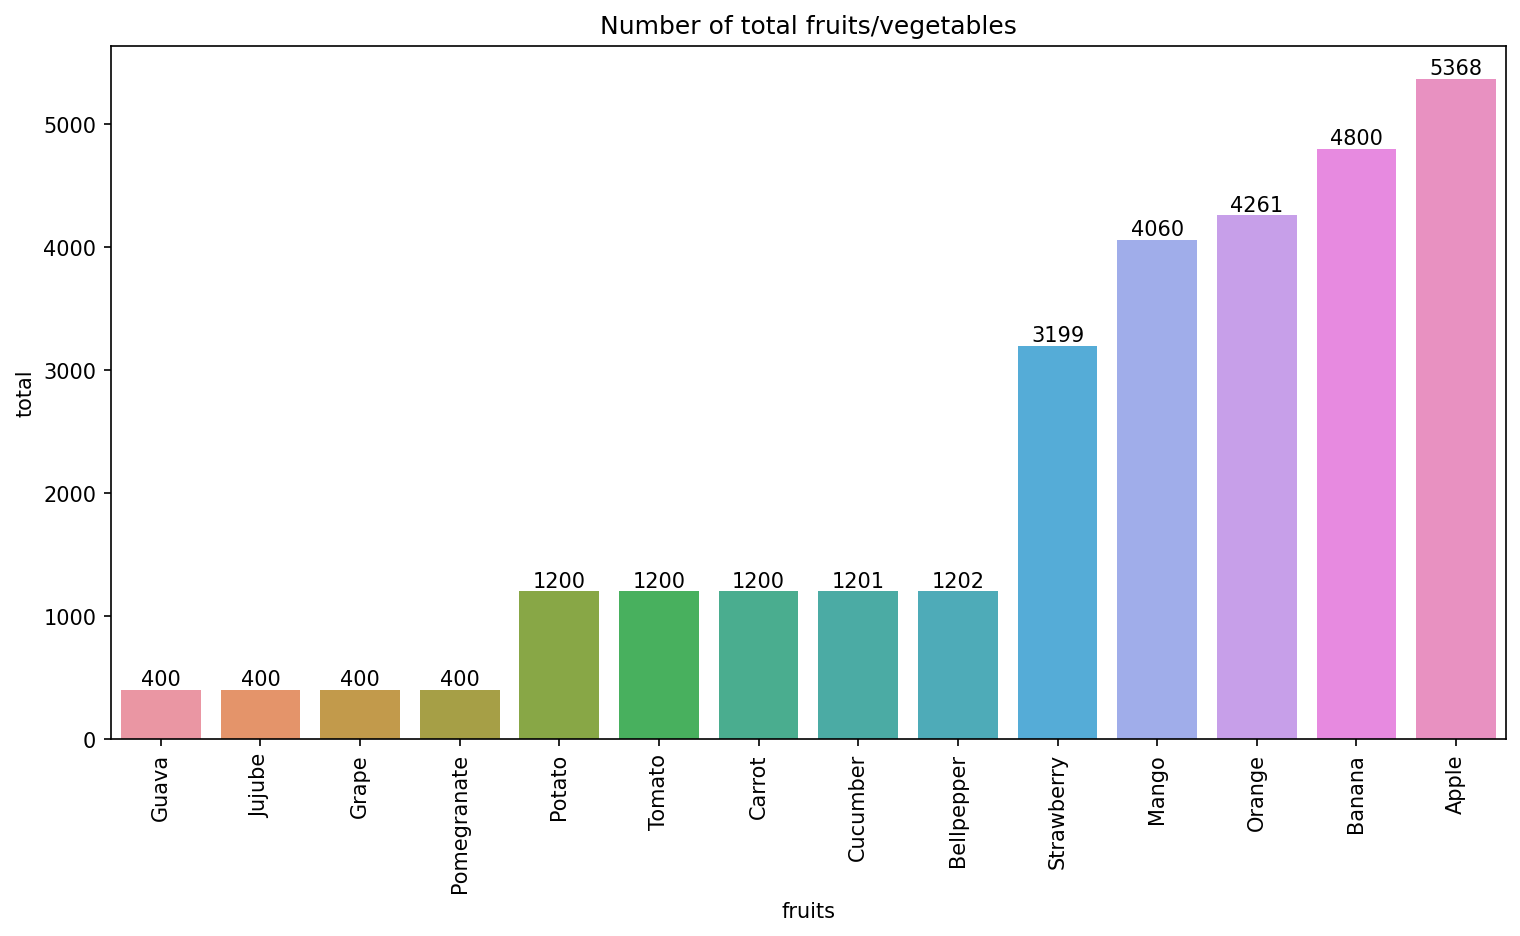

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of total fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='total')
ax.bar_label(ax.containers[0], fontsize=10);

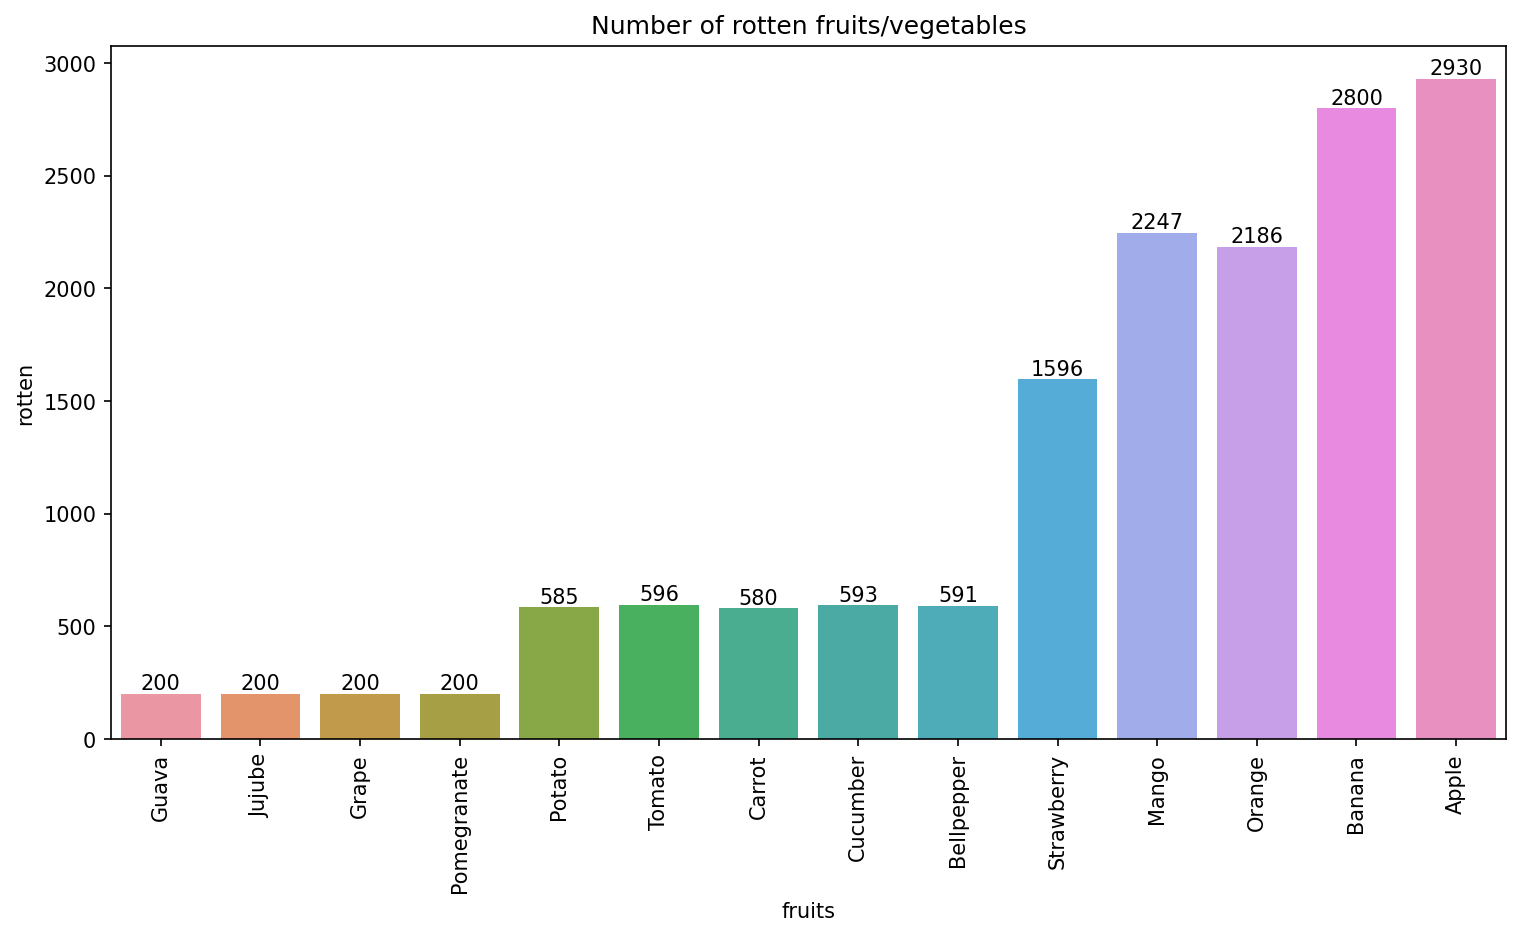

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of rotten fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='rotten')
ax.bar_label(ax.containers[0], fontsize=10);

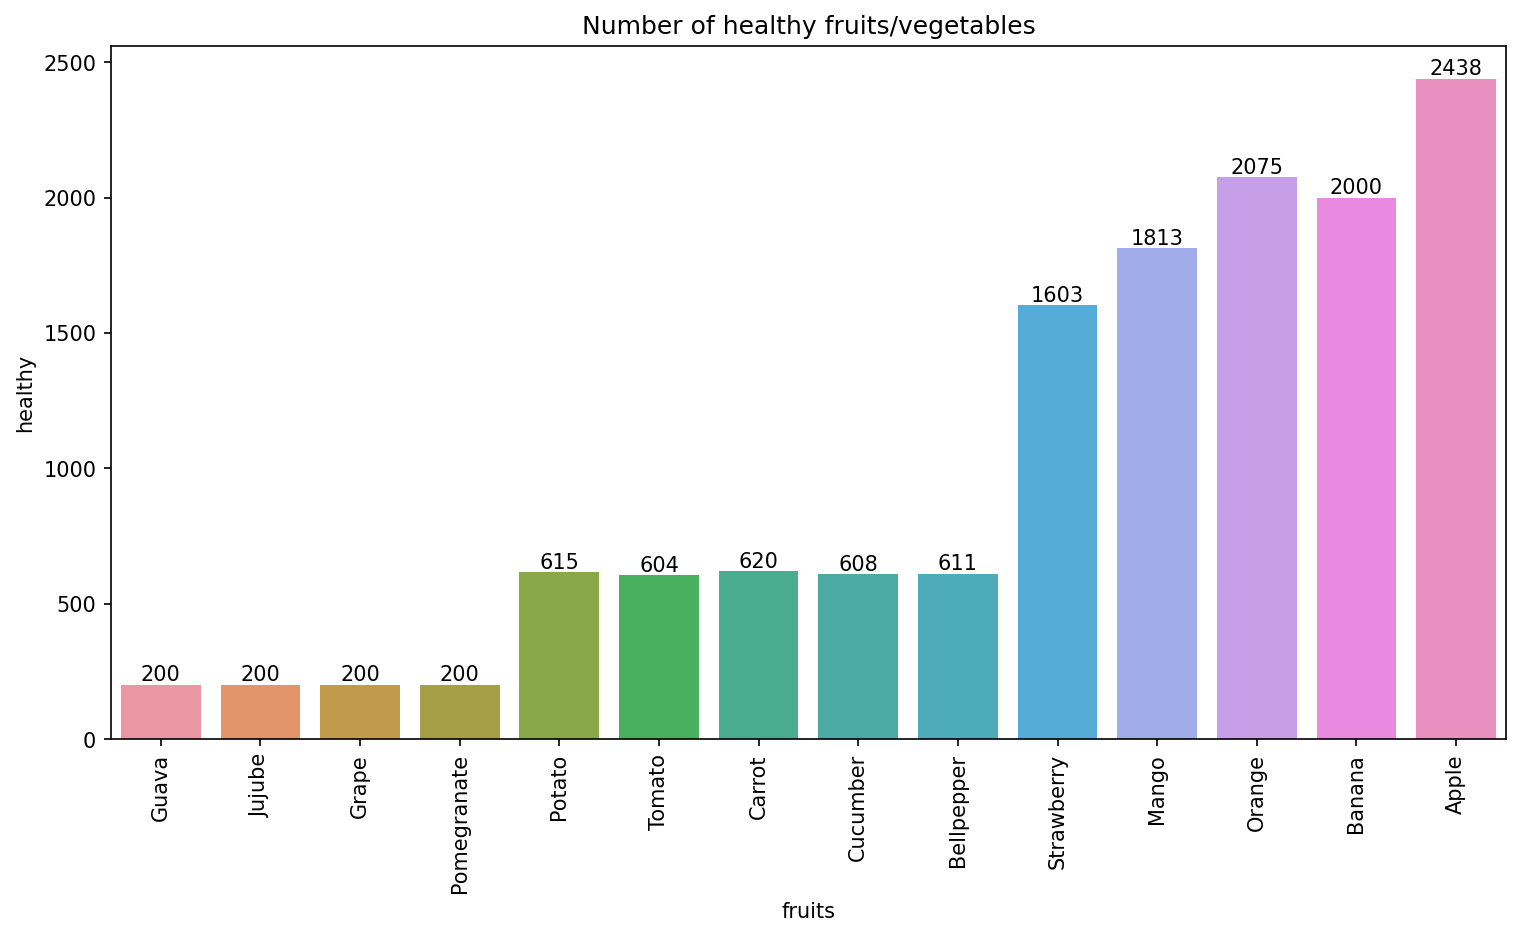

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of healthy fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='healthy')
ax.bar_label(ax.containers[0], fontsize=10);

In [ ]:
!python fastcopy.py /content/drive/MyDrive/Healthy_Rotten_Dataset/Input/ /training-images/ --thread 50

29291 file(s) to copy from /content/drive/MyDrive/Healthy_Rotten_Dataset/Input to /training-images with a size of 5.2GB
50 copy daemons started
100%|███████████████████████████████████| 29291/29291 [00:10<00:00, 2793.42it/s]
29291/29291 files copied successfully.


In [ ]:
train_sub_directories = get_sub_directories(training_directory)

def get_image_extensions(dir_paths):
    image_extension_dict = {}
    for path in dir_paths:
        for filename in os.listdir(path):
            _, file_extension = os.path.splitext(filename)
            if file_extension not in image_extension_dict:
                image_extension_dict[file_extension] = 1
            else:
                image_extension_dict[file_extension] += 1
    return image_extension_dict

print(get_image_extensions(train_sub_directories))

{'.jpg': 28044, '.png': 11813, '.webp': 14, '.jpeg': 80, '.JPG': 47}


In [ ]:
def count_color_channels(folder_paths):
    channel_counts = {}
    mode_to_channels = {'L': 1, 'LA': 2, 'P': 1, 'RGB': 3, 'RGBA': 4, 'CMYK': 4, 'YCbCr': 3, 'HSV': 3, 'LAB': 3, 'I': 1, 'F': 1}
    for folder_path in folder_paths:
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                with Image.open(file_path) as img:
                    mode = img.mode
                    channels = mode_to_channels.get(mode)
                    if channels is not None:
                        if channels in channel_counts:
                            channel_counts[channels] += 1
                        else:
                            channel_counts[channels] = 1
                    else:
                        print(f"Unrecognized mode {mode} for file {file_path}")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return channel_counts

print(count_color_channels(train_sub_directories))

{3: 38954, 4: 1039, 1: 5}


In [ ]:
def convert_images_to_jpeg_and_rgb(directory):
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png', '.webp', '.jpeg', '.JPG')):
            file_path = os.path.join(directory, filename)
            new_file_path = os.path.join(directory, os.path.splitext(filename)[0] + '.jpg')

            with Image.open(file_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img.save(new_file_path, 'JPEG')

            if not filename.lower().endswith('.jpg'):
                os.remove(file_path)


def process_folder(folder_path):
    convert_images_to_jpeg_and_rgb(folder_path)
    print(f'Processed folder: {folder_path}')

with ProcessPoolExecutor() as executor:
    executor.map(process_folder, train_sub_directories)

print('All the images were converted to JPEG format and RGB color channel')

print(get_image_extensions(train_sub_directories))

print(count_color_channels(train_sub_directories))

Processed folder: /training-images/Banana__Healthy
Processed folder: /training-images/Bellpepper__Healthy
Processed folder: /training-images/Bellpepper__Rotten
Processed folder: /training-images/Carrot__Healthy
Processed folder: /training-images/Carrot__Rotten
Processed folder: /training-images/Apple__Healthy
Processed folder: /training-images/Cucumber__Healthy
Processed folder: /training-images/Grape__Healthy
Processed folder: /training-images/Grape__Rotten
Processed folder: /training-images/Banana__Rotten
Processed folder: /training-images/Guava__Healthy
Processed folder: /training-images/Apple__Rotten
Processed folder: /training-images/Cucumber__Rotten
Processed folder: /training-images/Mango__Healthy
Processed folder: /training-images/Mango__Rotten
Processed folder: /training-images/Guava__Rotten
Processed folder: /training-images/Jujube__Rotten
Processed folder: /training-images/Jujube__Healthy
Processed folder: /training-images/Orange__Healthy
Processed folder: /training-images/P

In [ ]:
# Moving 15 images of each class to validation and test directories
for root, _, _ in os.walk('/training-images'):
    if root.split('/')[-1] != 'training-images':
        for i in range(15):
            test_src = os.path.join(root, random.choice(os.listdir(root)))
            test_dst = '/test-images/' + root.split('/')[-1]
            shutil.move(test_src, test_dst)
            validation_src = os.path.join(root, random.choice(os.listdir(root)))
            validation_dst = '/validation-images/' + root.split('/')[-1]
            shutil.move(validation_src, validation_dst)

print("15 images of each types of rotten and healthy fruits and vegetables were moved to the validation and test directories.")

In [ ]:
def build_img_dataset(directory, BATCH_SIZE=32, SEED=101, IMG_SIZE=(224, 224), class_names=False, shuffle=True):
    dataset = keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        image_size=IMG_SIZE,
        interpolation='bilinear',
        shuffle=shuffle,
        seed=SEED
    )

    class_names = dataset.class_names

    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)

    return (dataset, class_names if class_names else None)

training_data = build_img_dataset(training_directory)[0]
validation_data = build_img_dataset(validation_directory)[0]
test_data, test_classes = build_img_dataset(test_directory, BATCH_SIZE=16, class_names=True)

Found 27398 files belonging to 28 classes.
Found 420 files belonging to 28 classes.
Found 420 files belonging to 28 classes.


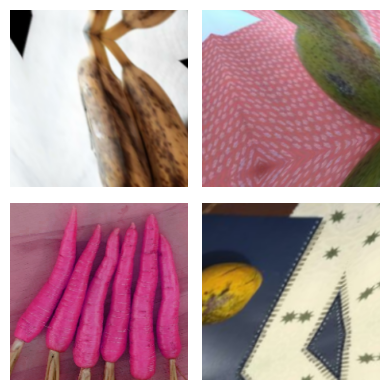

In [ ]:
def pack_to_dict(image, label):
    return {"images": image, "labels": label}

training_data = training_data.map(pack_to_dict, num_parallel_calls=tf.data.AUTOTUNE)

batch = next(iter(training_data.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

def visualize_images(rows=2, cols=2, augmentation=None, images=image_batch):
    keras_cv.visualization.plot_image_gallery(
        augmentation(image_batch) if augmentation else image_batch,
        rows=rows,
        cols=cols,
        value_range=(0, 255),
        show=True,
    )

random_flip = keras_cv.layers.RandomFlip(
    mode="horizontal_and_vertical"
)

random_crop_and_resize = keras_cv.layers.RandomCropAndResize(
    target_size = (224, 224),
    crop_area_factor = (0.8, 1.0),
    aspect_ratio_factor = (0.9, 1.1),
)

random_shear = keras_cv.layers.RandomShear(
    x_factor = (0.2, 0.4),
    y_factor = (0.2, 0.4),
    interpolation = "bilinear",
    fill_mode = "reflect",
)

random_hue = keras_cv.layers.RandomHue(
    factor = (0.2, 0.3),
    value_range = [0, 255]
)

aug_pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=[random_flip, random_crop_and_resize, random_hue, random_shear],
    augmentations_per_image=4,
)

training_data = training_data.map(aug_pipeline, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(training_data.take(1)))['images']
visualize_images(images = image_batch)

In [ ]:
def display_images_with_predictions_and_true_labels(dataset, model, test_classes, num_images=9):
    plt.figure(figsize=(10, 10))

    # Take a batch from the dataset and select random images
    for images, labels in dataset.take(1):
        indices = np.random.choice(images.shape[0], num_images, replace=False)
        random_images = images.numpy()[indices]
        true_labels = labels.numpy()[indices]

        # Convert true labels to integer indices if they are one-hot encoded
        if len(true_labels.shape) > 1:
            true_labels = np.argmax(true_labels, axis=1)

        predictions = model.predict(random_images)
        predicted_labels = np.argmax(predictions, axis=1)

        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(random_images[i].astype("uint8"))
            if true_labels[i] == predicted_labels[i]:
                color = 'green'
            else:
                color = 'red'
            plt.title(f"True: {test_classes[true_labels[i]]}\nPredicted: {test_classes[predicted_labels[i]]}",
                      color=color)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]

training_data = training_data.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
base_model_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

inputs_resnet = tf.keras.layers.Input(shape=(None, None, 3))
resized_inputs_resnet = tf.keras.layers.Resizing(224, 224)(inputs_resnet)
x_resnet = base_model_resnet(resized_inputs_resnet)
x_resnet = tf.keras.layers.BatchNormalization()(x_resnet)
x_resnet = tf.keras.layers.Dropout(0.5)(x_resnet)
outputs_resnet = tf.keras.layers.Dense(len(test_classes), activation='softmax')(x_resnet)
model_resnet = tf.keras.Model(inputs_resnet, outputs_resnet)

model_resnet.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

model_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │        57,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,653,276 (90.23 MB)

 Trainable params: 23,596,060 (90.01 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [ ]:
history = model_resnet.fit(
    training_data,
    validation_data=validation_data,
    epochs=10,
    verbose=1,
)

Epoch 1/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 380s 409ms/step - accuracy: 0.5432 - loss: 1.8370 - val_accuracy: 0.8976 - val_loss: 0.2845
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 281s 312ms/step - accuracy: 0.8532 - loss: 0.4783 - val_accuracy: 0.9452 - val_loss: 0.1555
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 269s 311ms/step - accuracy: 0.8889 - loss: 0.3684 - val_accuracy: 0.9357 - val_loss: 0.1879
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 269s 311ms/step - accuracy: 0.9095 - loss: 0.2839 - val_accuracy: 0.9405 - val_loss: 0.1885
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 270s 312ms/step - accuracy: 0.9241 - loss: 0.2403 - val_accuracy: 0.9333 - val_loss: 0.3412
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 269s 312ms/step - accuracy: 0.9276 - loss: 0.2329 - val_accuracy: 0.9286 - val_loss: 0.1997
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 268s 311ms/step - accuracy: 0.9295 - loss: 0.2242 - val_accuracy: 0.9571 - val_loss: 0.1505
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 268s 310ms/step - accuracy: 0.9381 -

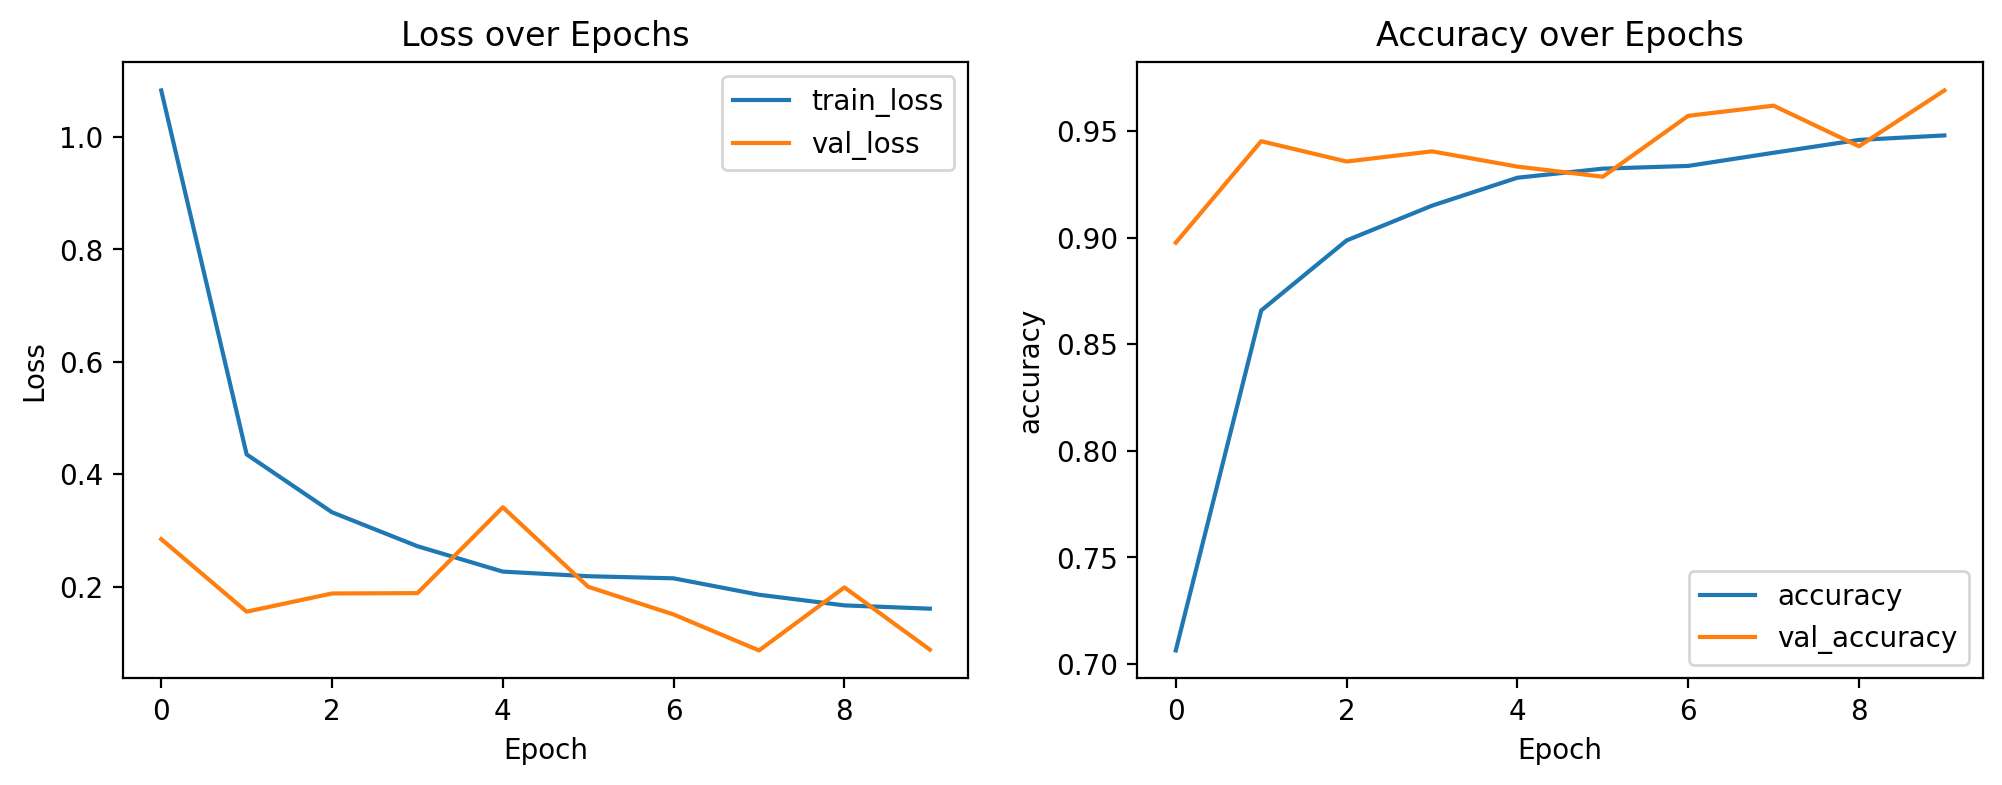

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show();

In [ ]:
loss, accuracy = model_resnet.evaluate(test_data)
print(f"The model loss on the test dataset is {round(loss, 4)}.")
print(f"The model accuracy on the test dataset is {round(accuracy, 2)*100}%.")

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9534 - loss: 0.2973
The model loss on the test dataset is 0.214.
The model accuracy on the test dataset is 95.0%.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


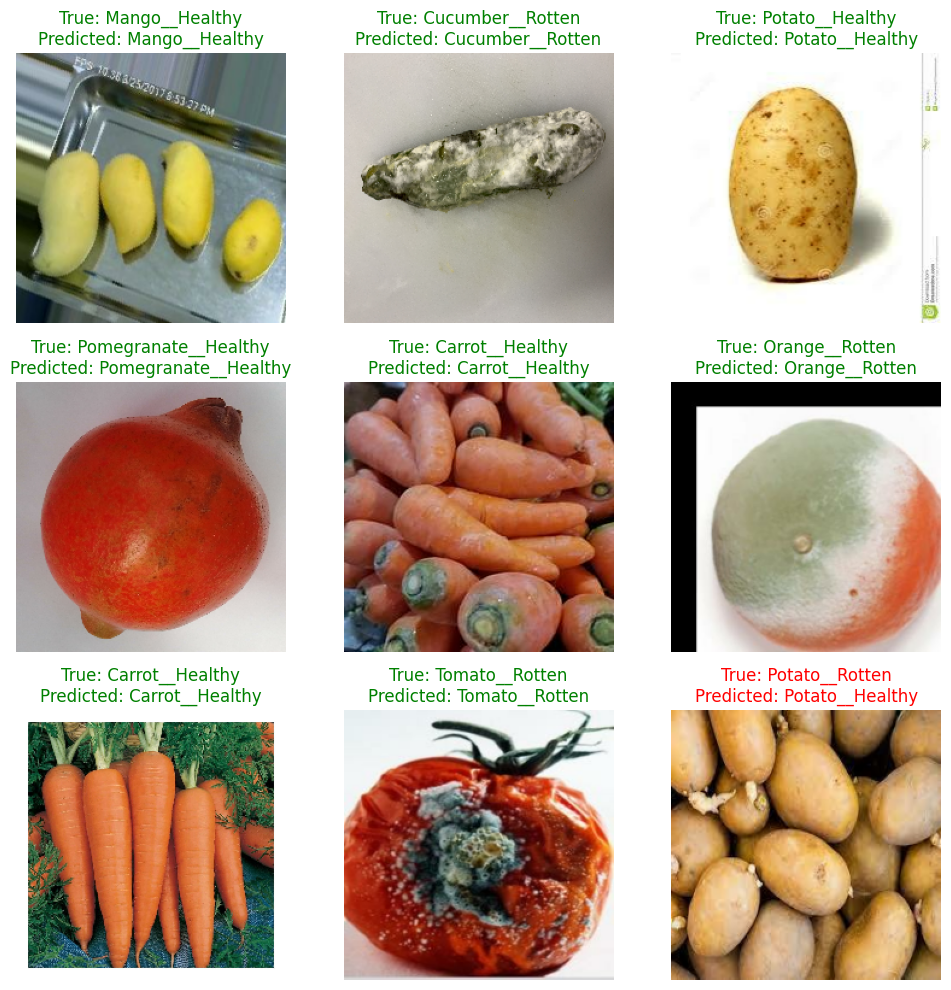

In [ ]:
display_images_with_predictions_and_true_labels(test_data, model_resnet, test_classes)

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    include_preprocessing=True
)

inputs = tf.keras.layers.Input(shape=(None, None, 3))
resized_inputs = tf.keras.layers.Resizing(224, 224)(inputs)
x = base_model(resized_inputs)
outputs = tf.keras.layers.Dense(len(test_classes), activation='softmax')(x)
model_efficientnet = tf.keras.Model(inputs, outputs)

model_efficientnet.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

model_efficientnet.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │        35,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,955,180 (22.72 MB)

 Trainable params: 5,894,572 (22.49 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
history = model_efficientnet.fit(
    training_data,
    validation_data=validation_data,
    epochs=10,
    verbose=1,
)

Epoch 1/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 351s 370ms/step - accuracy: 0.6023 - loss: 1.5215 - val_accuracy: 0.9405 - val_loss: 0.1960
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 285s 312ms/step - accuracy: 0.9180 - loss: 0.2720 - val_accuracy: 0.9714 - val_loss: 0.0821
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 268s 311ms/step - accuracy: 0.9404 - loss: 0.1833 - val_accuracy: 0.9786 - val_loss: 0.0561
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 267s 309ms/step - accuracy: 0.9594 - loss: 0.1310 - val_accuracy: 0.9833 - val_loss: 0.0510
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 270s 313ms/step - accuracy: 0.9672 - loss: 0.1043 - val_accuracy: 0.9810 - val_loss: 0.0525
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 266s 308ms/step - accuracy: 0.9719 - loss: 0.0856 - val_accuracy: 0.9833 - val_loss: 0.0379
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 266s 308ms/step - accuracy: 0.9761 - loss: 0.0741 - val_accuracy: 0.9833 - val_loss: 0.0404
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 266s 308ms/step - accuracy: 0.9769 -

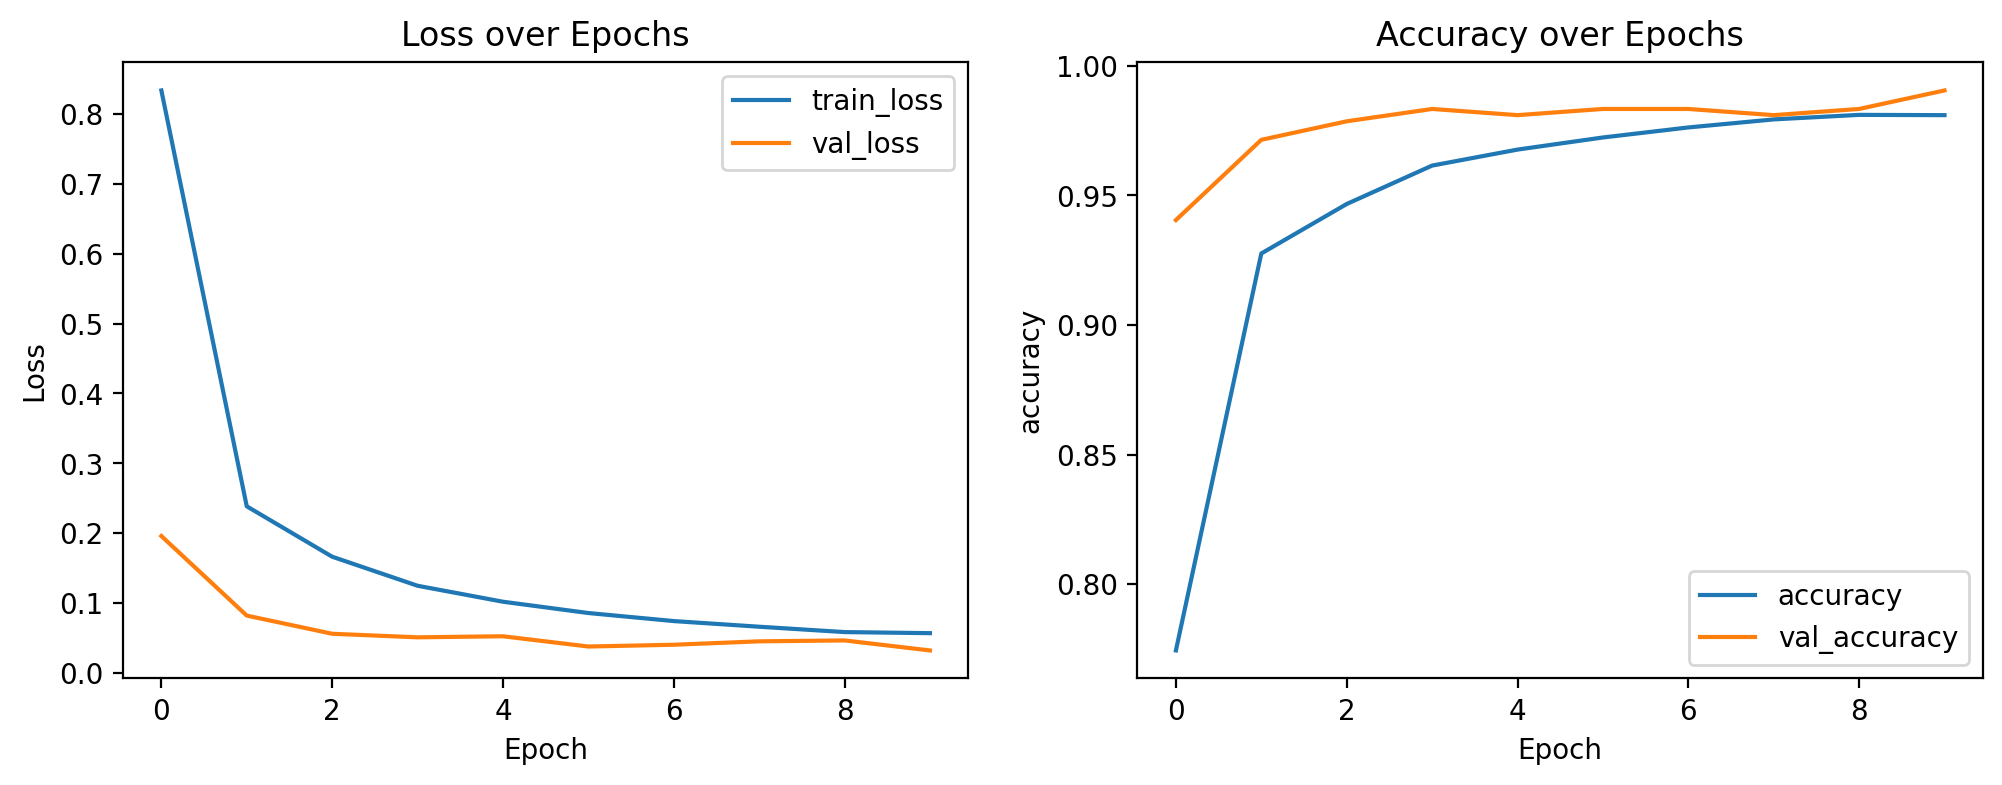

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show();

In [ ]:
loss, accuracy = model_efficientnet.evaluate(test_data)
print(f"The model loss on the test dataset is {round(loss, 4)}.")
print(f"The model accuracy on the test dataset is {round(accuracy, 2)*100}%.")

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9699 - loss: 0.1080 
The model loss on the test dataset is 0.0733.
The model accuracy on the test dataset is 98.0%.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


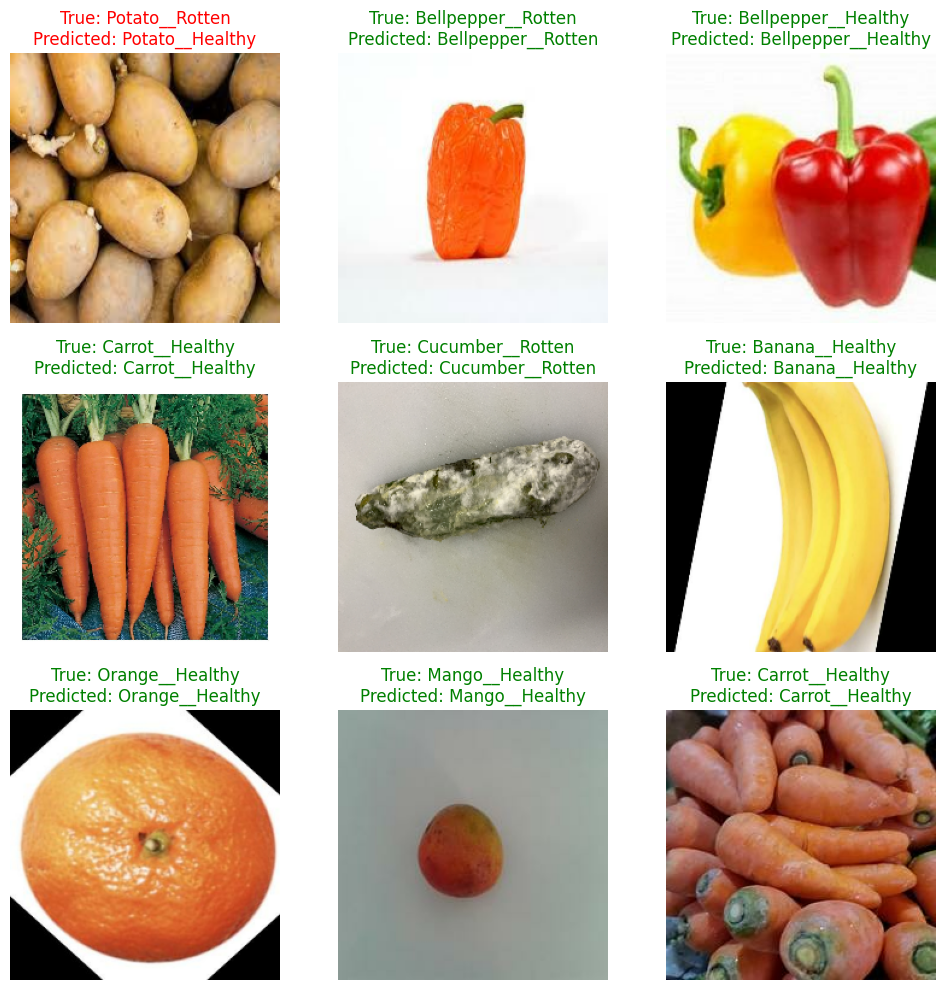

In [ ]:
display_images_with_predictions_and_true_labels(test_data, model_efficientnet, test_classes)

In [ ]:
base_model_mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

inputs_mobilenet = tf.keras.layers.Input(shape=(None, None, 3))
resized_inputs_mobilenet = tf.keras.layers.Resizing(224, 224)(inputs_mobilenet)
x_mobilenet = base_model_mobilenet(resized_inputs_mobilenet)
outputs_mobilenet = tf.keras.layers.Dense(len(test_classes), activation='softmax')(x_mobilenet)
model_mobilenet = tf.keras.Model(inputs_mobilenet, outputs_mobilenet)

model_mobilenet.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │        35,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,293,852 (8.75 MB)

 Trainable params: 2,259,740 (8.62 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
history = model_mobilenet.fit(
    training_data,
    validation_data=validation_data,
    epochs=8,
    verbose=1,
)

Epoch 1/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 322s 347ms/step - accuracy: 0.6753 - loss: 1.1671 - val_accuracy: 0.7571 - val_loss: 0.7503
Epoch 2/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 272s 303ms/step - accuracy: 0.9135 - loss: 0.2766 - val_accuracy: 0.9024 - val_loss: 0.2901
Epoch 3/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 263s 305ms/step - accuracy: 0.9359 - loss: 0.1941 - val_accuracy: 0.9524 - val_loss: 0.1423
Epoch 4/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 262s 303ms/step - accuracy: 0.9485 - loss: 0.1601 - val_accuracy: 0.9738 - val_loss: 0.0848
Epoch 5/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 262s 303ms/step - accuracy: 0.9579 - loss: 0.1244 - val_accuracy: 0.9262 - val_loss: 0.1855
Epoch 6/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 262s 303ms/step - accuracy: 0.9625 - loss: 0.1142 - val_accuracy: 0.9476 - val_loss: 0.1516
Epoch 7/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 259s 300ms/step - accuracy: 0.9680 - loss: 0.0990 - val_accuracy: 0.9619 - val_loss: 0.1058
Epoch 8/8
857/857 ━━━━━━━━━━━━━━━━━━━━ 259s 300ms/step - accuracy: 0.9679 - loss: 0

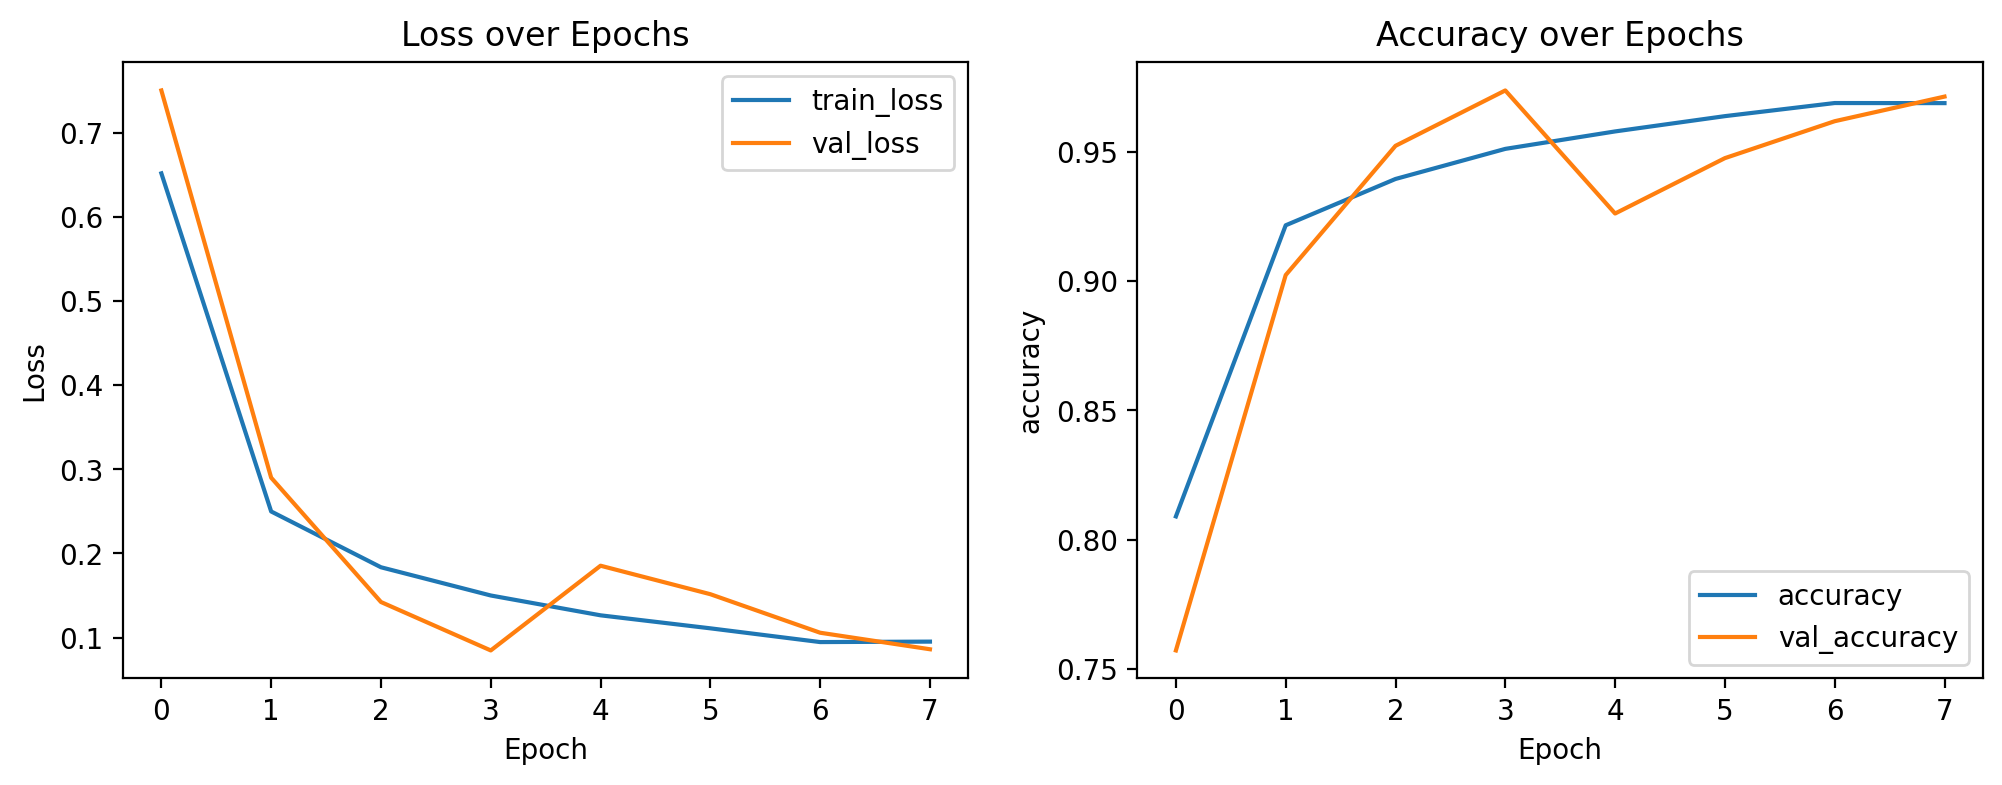

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show();

In [ ]:
loss, accuracy = model_mobilenet.evaluate(test_data)
print(f"The model loss on the test dataset is {round(loss, 4)}.")
print(f"The model accuracy on the test dataset is {round(accuracy, 2)*100}%.")

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9639 - loss: 0.1077
The model loss on the test dataset is 0.1075.
The model accuracy on the test dataset is 96.0%.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


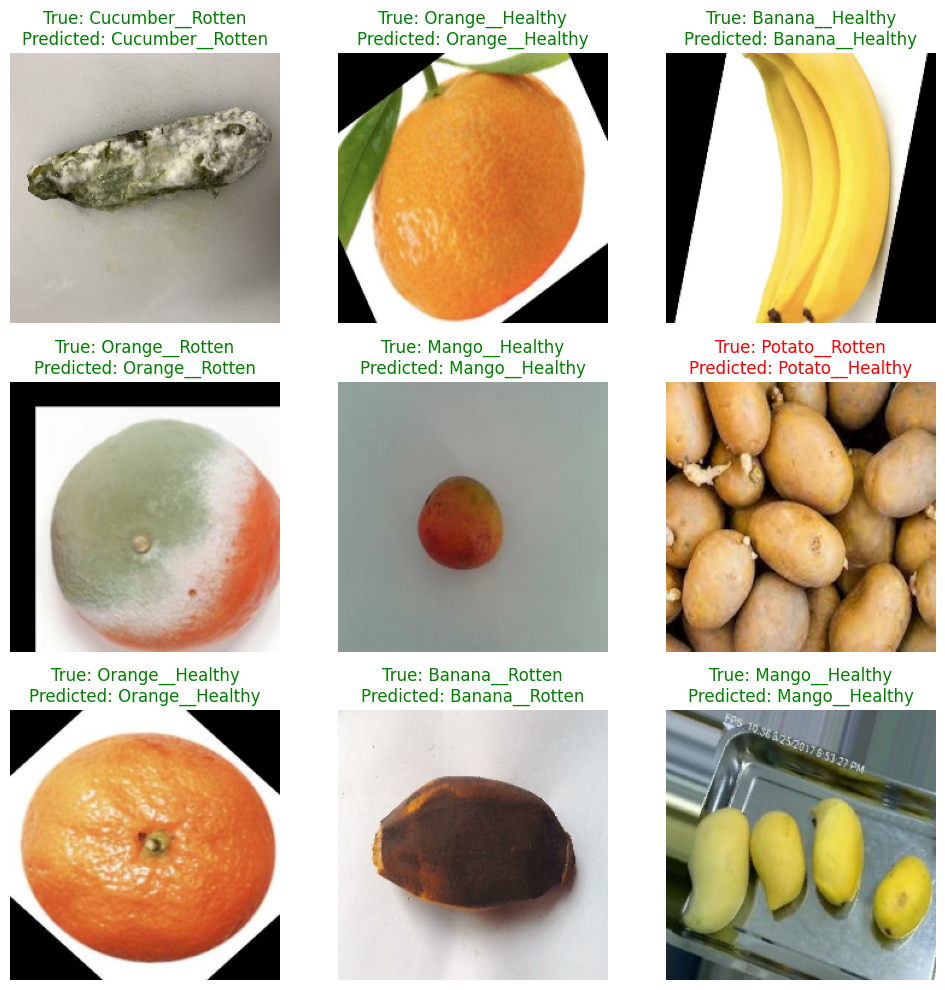

In [ ]:
display_images_with_predictions_and_true_labels(test_data, model_mobilenet, test_classes)

In [ ]:
# Function to convert bounding boxes to YOLO format
def convert_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x_center = (box[0] + box[2]) / 2.0 * dw
    y_center = (box[1] + box[3]) / 2.0 * dh
    width = (box[2] - box[0]) * dw
    height = (box[3] - box[1]) * dh
    return x_center, y_center, width, height

# Define directories
base_dir = '/Healthy Rotten Dataset'
input_dirs = {'training-images': 'train', 'validation-images': 'val', 'test-images': 'test'}
BATCH_SIZE = 10

model = YOLO('yolov8x.pt', verbose=False)

for input_directory, output_directory in input_dirs.items():
    input_dir = f'/{input_directory}'
    output_images_dir = os.path.join(base_dir, 'images', output_directory)
    output_labels_dir = os.path.join(base_dir, 'labels', output_directory)
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    class_mapping = {'Healthy': 0, 'Rotten': 1}
    for subfolder in os.listdir(input_dir):
        subfolder_path = os.path.join(input_dir, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        class_id = class_mapping['Healthy'] if 'Healthy' in subfolder else class_mapping['Rotten']
        img_batch = []
        for idx, img_file in enumerate(os.listdir(subfolder_path)):
            img_path = os.path.join(subfolder_path, img_file)
            img_batch.append(img_path)

            if len(img_batch) == BATCH_SIZE or idx == len(os.listdir(subfolder_path)) - 1:
                results = model(img_batch, conf=0.1, verbose=False)
                for i, result in enumerate(results):
                    img = cv2.imread(img_batch[i])
                    height, width, _ = img.shape
                    output_img_path = os.path.join(output_images_dir, subfolder + f"_{idx - len(img_batch) + i}.jpg")
                    shutil.copy(img_batch[i], output_img_path)
                    output_txt_path = os.path.join(output_labels_dir, subfolder + f"_{idx - len(img_batch) + i}.txt")
                    with open(output_txt_path, 'w') as f:
                        for box in result.boxes:
                            x1, y1, x2, y2 = box.xyxy[0]
                            x_center, y_center, w, h = convert_to_yolo((width, height), (x1, y1, x2, y2))
                            f.write(f"{class_id} {x_center} {y_center} {w} {h}\n")
                img_batch.clear()
                torch.cuda.empty_cache()  # Free GPU memory



In [ ]:
data_yaml_content = f"""
train: {base_dir}/images/train
val: {base_dir}/images/val
test: {base_dir}/images/test

nc: 2
names: ['Healthy', 'Rotten']
"""

with open(f'{base_dir}/data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [ ]:
# Load YOLOv8 model
model_yolo = YOLO('yolov8l.pt')

# Train the model on your dataset
model_yolo.train(
    data=f'{base_dir}/data.yaml',
    epochs=10,
    batch=16,
    optimizer='Adam',
    name='yolo_fruit_veg_optimized',
    augment=True,
    flipud=0.5,
    fliplr=0.5,
    mosaic=0.5,
    mixup=0.1,
    half=True
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 83.7M/83.7M [00:00<00:00, 302MB/s]


Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/Healthy Rotten Dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo_fruit_veg_optimized, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.4MB/s]


AMP: checks passed ✅


train: Scanning /Healthy Rotten Dataset/labels/train... 27349 images, 1354 backgrounds, 0 corrupt: 100%|██████████| 27349/27349 [04:40<00:00, 97.41it/s] 


train: WARNING ⚠️ Cache directory /Healthy Rotten Dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /Healthy Rotten Dataset/labels/val... 420 images, 20 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:04<00:00, 96.52it/s] 

val: WARNING ⚠️ Cache directory /Healthy Rotten Dataset/labels is not writeable, cache not saved.


Plotting labels to runs/detect/yolo_fruit_veg_optimized/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo_fruit_veg_optimized
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.4G      1.101      1.792      1.674         12        640: 100%|██████████| 1710/1710 [23:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


                   all        420       1128      0.479      0.343      0.337      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      10.6G     0.9431      1.543      1.533          9        640: 100%|██████████| 1710/1710 [22:44<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]

                   all        420       1128      0.442        0.4       0.37       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      10.3G     0.8619      1.415      1.446         15        640: 100%|██████████| 1710/1710 [22:36<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        420       1128      0.523      0.401      0.396      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      10.4G     0.7823      1.318      1.375         20        640: 100%|██████████| 1710/1710 [22:30<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]

                   all        420       1128      0.534      0.459      0.482      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      10.6G     0.7228      1.243      1.318         35        640: 100%|██████████| 1710/1710 [22:26<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]

                   all        420       1128      0.476      0.535      0.488      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      10.4G     0.6736      1.179      1.272          9        640: 100%|██████████| 1710/1710 [22:24<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]

                   all        420       1128      0.512      0.513      0.496      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      10.5G     0.6355      1.115      1.241         10        640: 100%|██████████| 1710/1710 [22:24<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]

                   all        420       1128       0.58      0.558      0.531      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      10.5G     0.5911      1.055      1.205          9        640: 100%|██████████| 1710/1710 [22:50<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]

                   all        420       1128      0.611      0.553       0.56      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      10.5G     0.5513     0.9988      1.172         20        640: 100%|██████████| 1710/1710 [22:20<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]

                   all        420       1128      0.631      0.582      0.588      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      10.5G     0.5131     0.9414      1.141          8        640: 100%|██████████| 1710/1710 [22:18<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]

                   all        420       1128      0.629      0.587      0.603      0.524



10 epochs completed in 3.794 hours.
Optimizer stripped from runs/detect/yolo_fruit_veg_optimized/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/yolo_fruit_veg_optimized/weights/best.pt, 87.6MB

Validating runs/detect/yolo_fruit_veg_optimized/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


                   all        420       1128      0.701      0.542       0.61      0.536
               Healthy        198        667      0.669      0.574      0.616      0.541
                Rotten        202        461      0.733       0.51      0.605      0.532
Speed: 0.2ms preprocess, 36.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/yolo_fruit_veg_optimized


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dca5e2b89d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
model_yolo.info()

Model summary (fused): 268 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


(268, 43608150, 0, 164.82124800000003)

In [ ]:
# Run validation on the validation set
results = model_yolo.val()

Ultralytics 8.3.31 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)


100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]
val: Scanning /Healthy Rotten Dataset/labels/val... 420 images, 20 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:03<00:00, 129.25it/s]


val: WARNING ⚠️ Cache directory /Healthy Rotten Dataset/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:15<00:00,  1.70it/s]


                   all        420       1128      0.765      0.583      0.691      0.622
               Healthy        198        667      0.765      0.586      0.701      0.634
                Rotten        202        461      0.765      0.581      0.681      0.611
Speed: 0.6ms preprocess, 29.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val3


In [ ]:
# Print YOLOv8 metrics after validation
print(f"YOLO mAP: {results.box.map.mean():.4f}")
print(f"YOLO Precision: {results.box.mp.mean():.4f}")
print(f"YOLO Recall: {results.box.mr.mean():.4f}")
print(f"YOLO F1 Score: {results.box.f1.mean():.4f}")


YOLO mAP: 0.6225
YOLO Precision: 0.7648
YOLO Recall: 0.5834
YOLO F1 Score: 0.6619
